# Desafio Sprint 3

## Etapa 1: ambiente

Nesta etapa devemos certificar que as bibliotecas **pandas** e **matplotlib** estão instaladas no ambiente atual.
Podemos importar ambas as bibliotecas com o comando:
```bash
python.exe -m pip install matplotlib pandas
```

Ao longo do projeto, também serão necessárias algumas bibliotecas adicionais.
```bash
python.exe -m pip install tabulate Jinja2
```

Portanto recomenda-se instalar os pacotes necessários lendo o arquivo [requirements.txt](requirements.txt):
```bash
# Rodar comando na pasta do desafio
python.exe -m pip install -r requirements.txt
```

Podemos conferir a lista de pacotes instalados usando o comando:
```bash
python.exe -m pip freeze
```

## Etapa 2: desenvolvimento

Funcões utilitárias:

In [23]:
import pandas as pd # Biblioteca de tratamento de dados
from IPython.display import display, Markdown # Exibição dos dados em tabelas markdown
from random import randint  # Função para gerar números aleatórios
from matplotlib import pyplot as plt # Biblioteca para plotar gráficos

#Nome das colunas do CSV como constantes
APP =                  "App"
CATEGORY =        "Category"
RATING =            "Rating"
REVIEWS =          "Reviews"
SIZE =               "Size"
INSTALLS =        "Installs"
TYPE =                "Type"
PRICE =              "Price"
AGE_RANGE = "Content Rating"
GENRE =            "Genres"
L_UPDATE =    "Last Updated"
C_VERSION =    "Current Ver"
A_VERSION =    "Android Ver"

# Funcao para exibir dataframes como tabelas markdown no notebook
def display_df_table(table, show_index=True) -> None:
    display(Markdown(table.to_markdown(index=show_index)))

### 1. Leitura e Tratamento dos Dados de [googleplaystore.csv](./googleplaystore.csv)

Como primeiro passo devemos importar os dados. 

In [24]:
raw_dataframe = pd.read_csv("googleplaystore.csv") # Caminho relativo ao path deste notebook

# Mostrando primeiro registro do csv
display_df_table(raw_dataframe.head(1))

|    | App                                            | Category       |   Rating |   Reviews | Size   | Installs   | Type   |   Price | Content Rating   | Genres       | Last Updated    | Current Ver   | Android Ver   |
|---:|:-----------------------------------------------|:---------------|---------:|----------:|:-------|:-----------|:-------|--------:|:-----------------|:-------------|:----------------|:--------------|:--------------|
|  0 | Photo Editor & Candy Camera & Grid & ScrapBook | ART_AND_DESIGN |      4.1 |       159 | 19M    | 10,000+    | Free   |       0 | Everyone         | Art & Design | January 7, 2018 | 1.0.0         | 4.0.3 and up  |

Em seguida podemos remover todos os registros duplicados

In [25]:
# Removendo duplicatas
distinct_dataframe = raw_dataframe.drop_duplicates()
removed_registers = (len(raw_dataframe) - len(distinct_dataframe))

print(f"Número de Registros Bruto: {len(raw_dataframe):>14}")
print(f"Número de Registros Distintos: {len(distinct_dataframe):>10}")
print(f"Número de Registros Removidos: {removed_registers:>10}")

Número de Registros Bruto:          10841
Número de Registros Distintos:      10358
Número de Registros Removidos:        483


Podemos agora analisar o formato dos dados de cada coluna e tratar/filtrar de forma mais profunda

### 2. Os 5 Aplicativos Mais Instalados

Para descobrirmos os aplicativos mais instalados da plataforma, podemos utilizar o campo "Installs" encontrado na tabela que apresenta o número de instalações no seguinte padrão:

In [26]:
# Exibindo 5 registros variados da coluna "Installs"
display_df_table(distinct_dataframe[::randint(1700, 2000)][INSTALLS].head())
# Este bloco pode ser executado diversas vezes para ter maior noção dos dados

|      | Installs   |
|-----:|:-----------|
|    0 | 10,000+    |
| 2157 | 1,000,000+ |
| 4296 | 500,000+   |
| 6222 | 1,000+     |
| 8155 | 1,000+     |

Os valores se encontram no formato americano ("," como separador de milhares) com um "+" ao final. 

Podemos assumir que esta coluna deve receber apenas valores com o conjunto de caracteres descritos acima: 

In [27]:
# Expressao regular que verifica se a string possui apenas 
# números, "," e "+".
installs_pattern = r"([\d,+]+)"

# Cria uma máscara de busca para valores que atendem a expressão regular
intalls_pattern_mask = distinct_dataframe[INSTALLS].str.match(installs_pattern)

# Usa a máscara criada para retornar registros com valores válidos
valid_installs_dataframe = distinct_dataframe[intalls_pattern_mask]

installs_removed_registers = len(distinct_dataframe) - len(valid_installs_dataframe)

print(f"Número de registros antes do tratamento de {INSTALLS}: {len(distinct_dataframe):>10}")
print(f"Número de valores válidos na coluna {INSTALLS}: {len(valid_installs_dataframe):>17}")
print(f"Número de registros removidos em {INSTALLS}: {installs_removed_registers:>20}")

Número de registros antes do tratamento de Installs:      10358
Número de valores válidos na coluna Installs:             10357
Número de registros removidos em Installs:                    1


Por fim, podemos organizar os aplicativos pelo número de instalações:

In [28]:
# Cria uma cópia do dataframe 
normalized_installs_dataframe = valid_installs_dataframe.copy(deep=True)

# Converte valores de install para valores numéricos
normalized_installs_dataframe[INSTALLS] = normalized_installs_dataframe[INSTALLS].apply(
    # Remove "," e "+" e converte para inteiro
    lambda n: int(n.replace(",", "").replace("+", ""))
)

# Dataframe com registros ordenados por numero de instalações e nome
most_installs_dataframe = normalized_installs_dataframe[[APP, INSTALLS]].sort_values(by=[INSTALLS, APP], ascending=[False, True])

# Dataframe com os 10 apps com mais instalações
installs_dataframe_for_plot = most_installs_dataframe.drop_duplicates()

display(installs_dataframe_for_plot.head(10).style.format(thousands="."))

,App,Installs
2544,Facebook,1.000.000.000
340,Gmail,1.000.000.000
3234,Google,1.000.000.000
338,Google Chrome: Fast & Secure,1.000.000.000
3454,Google Drive,1.000.000.000
3736,Google News,1.000.000.000
2808,Google Photos,1.000.000.000
152,Google Play Books,1.000.000.000
865,Google Play Games,1.000.000.000
3687,Google Play Movies & TV,1.000.000.000


Infelizmente os registros encontrados apontam para aplicativos que muitas vezes vem instalados de fábrica no dispositivo.

Vamos fazer uma lista de palavras chaves destes apps e ignorá-los na análise:

In [29]:
# Lista de palvras chaves para ignorar apps
ignore_list = ["google", "gmail", "youtube"]

# Mascara que valida apenas valores que pertencem a lista de apps ignorados
pre_installed_apps_mask = installs_dataframe_for_plot[APP].apply(str.lower).str.contains('|'.join(ignore_list))

# Dataframe com os 10 apps com mais instalações excluindo os apps da lista ignore_list
not_pre_installs_dataframe = installs_dataframe_for_plot[~pre_installed_apps_mask]

display(not_pre_installs_dataframe.head(10).style.format(thousands="."))

,App,Installs
2544,Facebook,1.000.000.000
341,Hangouts,1.000.000.000
2545,Instagram,1.000.000.000
3117,Maps - Navigate & Explore,1.000.000.000
335,Messenger – Text and Video Chat for Free,1.000.000.000
391,Skype - free IM & video calls,1.000.000.000
1654,Subway Surfers,1.000.000.000
336,WhatsApp Messenger,1.000.000.000
1655,Candy Crush Saga,500.000.000
4005,Clean Master- Space Cleaner & Antivirus,500.000.000


Gerando o gráfico pedido:

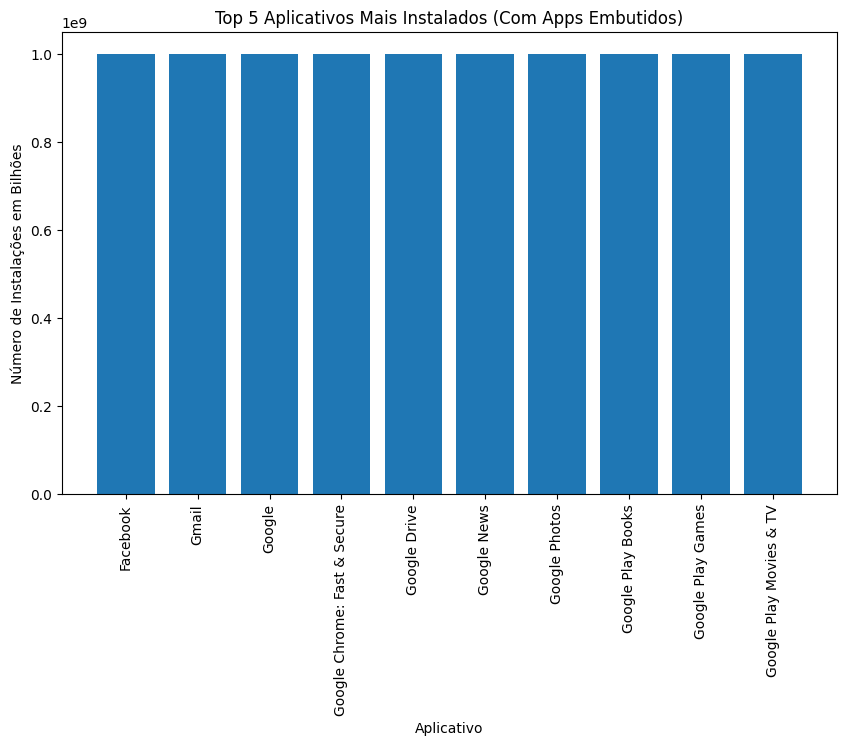

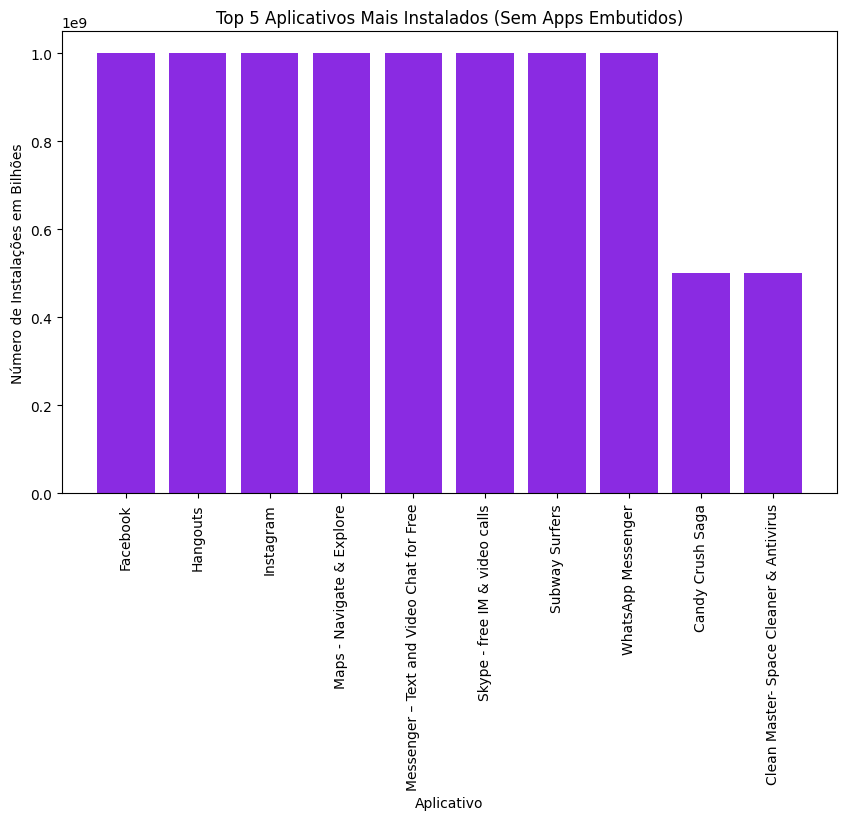

In [30]:
# Grafico de barras contando apps pre instalados_____________________________________
pre_installs_head = installs_dataframe_for_plot.head(10)

# Configurar o tamanho da figura
plt.figure(figsize=(10, 6))

# Criar o gráfico de barras
plt.bar(pre_installs_head[APP], pre_installs_head[INSTALLS])

# Rotacionar os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=90)

# Adicionar título e rótulos dos eixos
plt.title('Top 5 Aplicativos Mais Instalados (Com Apps Embutidos)')
plt.xlabel('Aplicativo')
plt.ylabel('Número de Instalações em Bilhões')

# Exibir o gráfico
plt.show()

# Grafico de barras sem apps pre instalados___________________________________________
not_pre_installs_head = not_pre_installs_dataframe.head(10)

# Configurar o tamanho da figura
plt.figure(figsize=(10, 6))

# Criar o gráfico de barras
plt.bar(not_pre_installs_head[APP], not_pre_installs_head[INSTALLS], color='blueviolet')

# Rotacionar os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=90)

# Adicionar título e rótulos dos eixos
plt.title('Top 5 Aplicativos Mais Instalados (Sem Apps Embutidos)')
plt.xlabel('Aplicativo')
plt.ylabel('Número de Instalações em Bilhões')

# Exibir o gráfico
plt.show()

### 3. Frequências de Categorias

Primeiramente vamos observar os dados da coluna "Category":

In [31]:
# Exibindo 5 registros variados da coluna "Category"
display_df_table(distinct_dataframe[::randint(1700, 2000)][CATEGORY].head())
# Este bloco pode ser executado diversas vezes para ter maior noção dos dados

|      | Category       |
|-----:|:---------------|
|    0 | ART_AND_DESIGN |
| 2119 | FAMILY         |
| 4225 | FAMILY         |
| 6117 | LIFESTYLE      |
| 8015 | FAMILY         |

Podemos notar que o formato padrão para esta coluna são palavras em letras maíuscula separadas por *underline*.

Vamos filtrar os registros que não seguem esta regra:

In [32]:
# Expressão regular que checa letras maíusculas e underline
category_pattern = r"[A-Z_]"

# Cria um objeto Series com valores True|False que serve como máscara de busca 
category_mask = distinct_dataframe[CATEGORY].str.match(category_pattern)

# Usa máscara criada para filtrar as linhas com "Category" válidas
valid_category_dataframe = distinct_dataframe[category_mask]

removed_registers = (len(distinct_dataframe) - len(valid_category_dataframe))

print(f"Número de Registros Bruto: {len(distinct_dataframe):>14}")
print(f"Número de Registros Válidos: {len(valid_category_dataframe):>12}")
print(f"Número de Registros Removidos: {removed_registers:>10}")

Número de Registros Bruto:          10358
Número de Registros Válidos:        10357
Número de Registros Removidos:          1


Agora podemos criar uma tabela com a frequência das categorias e gerar o gráfico pedido:

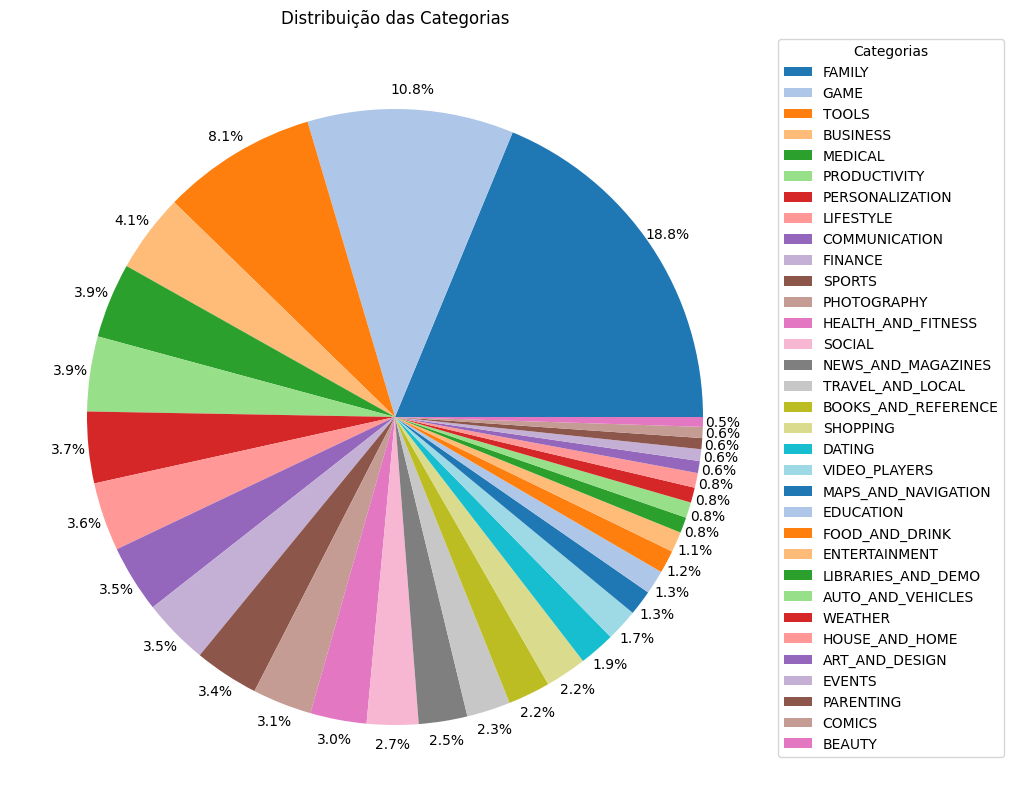

In [33]:
# Cria um novo dataframe com a contagem de registros por categoria
group_by_category_dataframe = valid_category_dataframe.groupby(CATEGORY).size().reset_index(name="Count")

# Ordenando as categorias por quantidade
sorted_group_by_category_dataframe = group_by_category_dataframe.sort_values(by="Count", ascending=False)


# Gerando gráfico com a contagem das categorias_________________________________________

# Extraindo os nomes das categorias e contagens do dataframe
categories = sorted_group_by_category_dataframe[CATEGORY]
counts = sorted_group_by_category_dataframe["Count"]

# Criando o grafico de pizza
plt.figure(figsize=(10, 10))
plt.pie(counts, 
        labels=None, 
        autopct='%1.1f%%', 
        startangle=0, 
        rotatelabels=True, 
        colors=plt.cm.tab20.colors, 
        pctdistance=1.065
)
plt.legend(categories, loc="upper right", 
           bbox_to_anchor=(0.8, 0, 0.5, 1), 
           title="Categorias"
)
plt.title("Distribuição das Categorias")

# Apresentando o gráfico
plt.show()

Como podemos notar, a visualição do gráfico é prejudicada pela quantidade excessiva de categorias existente na tabela.

Um alternativa neste caso seria um gráfico de barras contendo a contagem de cada categoria, vamos montar um para visualizar as frequências de cada categoria:

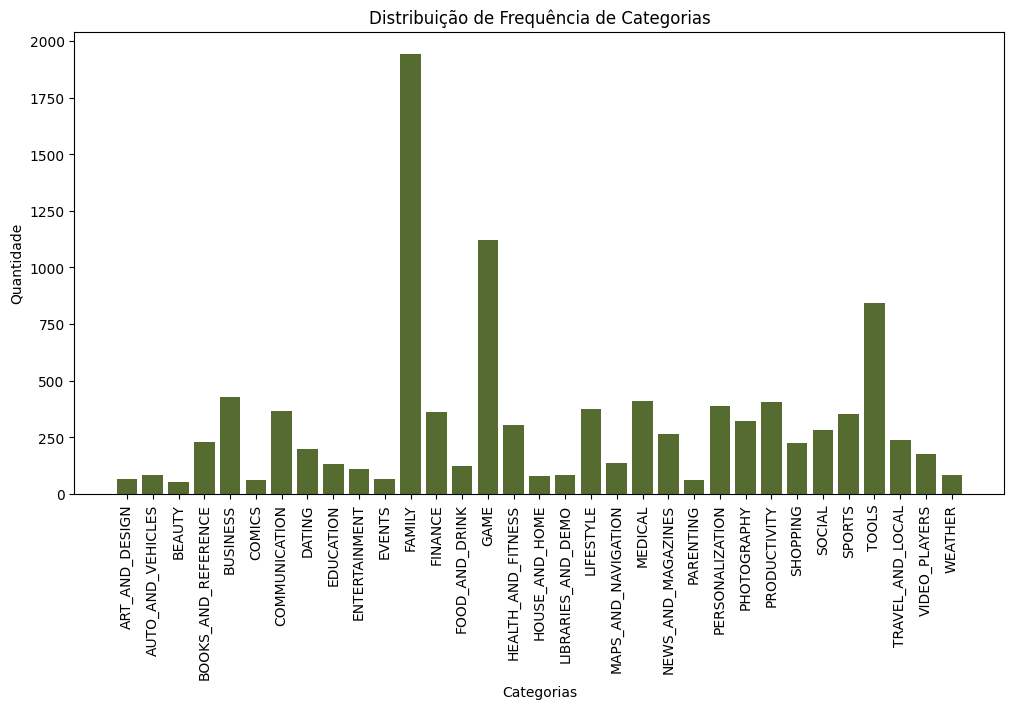

In [34]:
# Gerando gráfico de barras com a contagem das categorias_______________________________________
plt.figure(figsize=(12, 6))
plt.bar(group_by_category_dataframe[CATEGORY], group_by_category_dataframe['Count'], color='darkolivegreen')

# Adicionando rótulos e título
plt.xlabel('Categorias')
plt.ylabel('Quantidade')
plt.title('Distribuição de Frequência de Categorias')

# Rotacionando os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=90)

# Apresentando o gráfico
plt.show()

### 4. App Mais Caro do Dataset

Dentro da tabela, o campo "Price" nos indica o preço de cada aplicativo. 

Vamos observar os valores da coluna:

In [35]:
# Exibindo registros variados da coluna "price"
display_df_table(distinct_dataframe[::randint(50, 150)][PRICE].drop_duplicates().head())
# Este bloco pode ser executado diversas vezes para ter maior noção dos dados

|      | Price   |
|-----:|:--------|
|    0 | 0       |
| 4158 | $1.70   |
| 4488 | $0.99   |
| 5361 | $18.99  |

Os valores deste campo são compostos por um símbolo indicando a moeda, seguido do preço em decimal.

Vamos tratar estes dados, deixando apenas o valor númerico do campo e mostrar o app mais caro:

In [36]:
# Função para normalizar valores de preço
def normalize_price(value: str) -> float:
    if value.startswith("$"): return float(value[1:])
    
    try:
        return float(value)
    except ValueError:
        return float("nan")
    
# Cria uma cópia do dataframe
normalize_price_dataframe = distinct_dataframe.copy(deep=True)

# Substitue os valores da coluna "Price" por valores numericos
normalize_price_dataframe[PRICE] = normalize_price_dataframe[PRICE].apply(normalize_price)

# Selecionando o app com "Price" mais alto na tabela
most_expensive_app = normalize_price_dataframe.sort_values(by=PRICE, ascending=False).head(1)

print("\n", "Informações do App Mais Caro".center(80, "-"))
display_df_table(most_expensive_app, False)
print("-" * 80)


 --------------------------Informações do App Mais Caro--------------------------


| App                      | Category   |   Rating |   Reviews | Size   | Installs   | Type   |   Price | Content Rating   | Genres    | Last Updated   | Current Ver   | Android Ver   |
|:-------------------------|:-----------|---------:|----------:|:-------|:-----------|:-------|--------:|:-----------------|:----------|:---------------|:--------------|:--------------|
| I'm Rich - Trump Edition | LIFESTYLE  |      3.6 |       275 | 7.3M   | 10,000+    | Paid   |     400 | Everyone         | Lifestyle | May 3, 2018    | 1.0.1         | 4.1 and up    |

--------------------------------------------------------------------------------


### 5. Apps Classificados Como "Mature 17+"

A coluna "Content Rating" na tabela, nos indica a classificação indicativa de cada app.

Vamos observar como ela é padronizada:



In [37]:
# Mostra os diferentes registros da coluna "Content Rating"
display_df_table(distinct_dataframe[AGE_RANGE].drop_duplicates())

|       | Content Rating   |
|------:|:-----------------|
|     0 | Everyone         |
|     3 | Teen             |
|    22 | Everyone 10+     |
|   129 | Mature 17+       |
|   298 | Adults only 18+  |
|  7312 | Unrated          |
| 10472 | nan              |

Como queremos apenas visualizar o número de aplicativos classificados como "Mature 17+" não precisamos realizar nenhum tipo de tratamento.

In [38]:
# Cria um dataframe apenas com registros que possuem "Content Rating" igual a "Mature 17+"
mature_only_age_range_dataframe = distinct_dataframe[distinct_dataframe[AGE_RANGE] == "Mature 17+"]

# Exibe a quantidade de registros com "Content Rating" igual a "Mature 17+"
print("-" * 80)
print(f"Número de registros com {AGE_RANGE} igual a 'Mature 17+': {len(mature_only_age_range_dataframe)}")
print("-" * 80)

--------------------------------------------------------------------------------
Número de registros com Content Rating igual a 'Mature 17+': 447
--------------------------------------------------------------------------------


### 6. Os 10 Apps Mais Avaliados

Dentro da tabela, a coluna "Reviews" pode nos indicar algo. Seguindo a [políticas de avaliação](https://play.google/intl/pt-BR/comment-posting-policy/) da Google Play Store, podemos assumir que esta coluna representa a quantidade total de avaliações que um aplicativo possui.

Vamos tratar os valores inválidos o mostrar os aplicativos mais avaliados:

Obs: Podemos considerar inválido qualquer valor fora do conjunto $\mathbb{N}_0$

In [39]:
# Função para criar uma máscara que valida valores de "Reviews"
def create_review_mask(value: str) -> bool:
    try:
        # Verifica se o valor é um inteiro
        return int(value) == float(value)
    except ValueError:
        # Retorna False se o valor não for 
        # numericamente convertivel
        return False

# Máscara que valida apenas valores numéricos inteiros
reviews_mask = distinct_dataframe[REVIEWS].apply(create_review_mask)

# Cria dataframe apenas com valores que atendem a máscara
valid_reviews_dataframe = distinct_dataframe[reviews_mask]

# Cria um dataframe apenas com as colunas "App" e "Reviews" 
# e converte os valores em "Reviews" para inteiros
normalized_reviews_dataframe = valid_reviews_dataframe[[APP, REVIEWS]].astype({REVIEWS: int})

# Exibindo 10 registros com mais reviews
display(normalized_reviews_dataframe\
        .sort_values(by=[REVIEWS, APP], ascending=False).head(10)
        .style.format(thousands=".")
)

,App,Reviews
2544,Facebook,78.158.306
3943,Facebook,78.128.208
336,WhatsApp Messenger,69.119.316
3904,WhatsApp Messenger,69.109.672
2604,Instagram,66.577.446
2545,Instagram,66.577.313
3909,Instagram,66.509.917
382,Messenger – Text and Video Chat for Free,56.646.578
335,Messenger – Text and Video Chat for Free,56.642.847
1879,Clash of Clans,44.893.888


Como podemos notar, alguns apps aparecem mais de uma vez devido a diferentes versões registradas do mesmo app. 

Vamos considerar apenas as versões mais avaliadas de cada:

In [40]:
# Cria um dataframe com os registros de "App" e "Reviews" máximos
distinct_normalized_reviews_dataframe = normalized_reviews_dataframe.groupby(APP)[REVIEWS].max().reset_index()

# Exibindo 10 registros com mais reviews
print("Top 10 apps com mais avaliações".center(80, "-"))

display(distinct_normalized_reviews_dataframe
        .sort_values(by=REVIEWS, ascending=False).head(10)
        .style.format(thousands=".")
)

print("-" * 80)

------------------------Top 10 apps com mais avaliações-------------------------


,App,Reviews
4328,Facebook,78.158.306
9041,WhatsApp Messenger,69.119.316
5399,Instagram,66.577.446
6165,Messenger – Text and Video Chat for Free,56.646.578
2564,Clash of Clans,44.893.888
2573,Clean Master- Space Cleaner & Antivirus,42.916.526
8079,Subway Surfers,27.725.352
9225,YouTube,25.655.305
7721,"Security Master - Antivirus, VPN, AppLock, Booster",24.900.999
2561,Clash Royale,23.136.735


--------------------------------------------------------------------------------


### 7. Cálculos Adicionais

#### Top 10 Gêneros Mais Baixados

Para conseguirmos analisar os gêneros existentes de cada aplicativo vamos utilizar a coluna "Genres":

In [41]:
# Exibindo 5 registros variados da coluna "Genres"
display_df_table(distinct_dataframe[GENRE].drop_duplicates().head(5))

|    | Genres                          |
|---:|:--------------------------------|
|  0 | Art & Design                    |
|  1 | Art & Design;Pretend Play       |
|  4 | Art & Design;Creativity         |
| 23 | Art & Design;Action & Adventure |
| 49 | Auto & Vehicles                 |

Como podemos observar a coluna possuí vários gêneros separados por ";".

Vamos criar uma nova tabela apenas com "Installs" e "Genres" separando as células multivaloradas e aplicando o mesmo número de downloads para cada nova célula criada a partir da primeira:

In [42]:
# Cria um dataframe para a contagem de registros por gênero
ungrouped_genres_dataframe = pd.DataFrame(columns=[GENRE, INSTALLS])

# Reutilizando valores de "Installs" já tratados
# Na Etapa 2: Parte 2
genres_series = normalized_installs_dataframe[GENRE]
installs_series = normalized_installs_dataframe[INSTALLS]

for genre, installs in zip(genres_series, installs_series):
    # Separa os gêneros separados por ";"
    for single_genre in genre.split(";"):
        # Cria um novo registro com o gênero e o número de instalações
        new_row = pd.DataFrame([[single_genre, installs]], columns=[GENRE, INSTALLS])
        
        # Adiciona o gênero e o número de instalações ao dataframe
        ungrouped_genres_dataframe = pd.concat([new_row, ungrouped_genres_dataframe], ignore_index=True)
        
genres_added_registers = len(ungrouped_genres_dataframe) - len(normalized_installs_dataframe)

print(f"Número de registros antes do tratamento: {len(normalize_price_dataframe):>10}")
print(f"Número de registros após tratamento: {len(ungrouped_genres_dataframe):>14}")
print(f"Número de registros adicionados: {genres_added_registers:>18}")


Número de registros antes do tratamento:      10358
Número de registros após tratamento:          10819
Número de registros adicionados:                462


Podemos agora agrupar os gêneros e verificar os mais baixados:

In [43]:
# Agrupando por 'Gênero' e calculando a soma de 'Installs' para cada gênero
grouped_genres_dataframe = ungrouped_genres_dataframe.groupby(GENRE)[INSTALLS].sum().reset_index()

# Exibindo os 10 gêneros com mais instalações
print("Top 10 Gêneros com Mais Baixados".center(80, "-"))

display(grouped_genres_dataframe
        .sort_values(by='Installs', ascending=False).head(10)
        .style.format(thousands=".")
)

print("-" * 80)

------------------------Top 10 Gêneros com Mais Baixados------------------------


,Genres,Installs
15,Communication,24.152.776.251
44,Social,12.513.867.902
38,Productivity,12.463.091.369
47,Tools,11.452.771.915
3,Arcade,9.773.339.156
36,Photography,9.721.247.655
13,Casual,9.340.263.740
0,Action,8.409.059.690
48,Travel & Local,6.361.887.146
50,Video Players & Editors,6.242.002.720


--------------------------------------------------------------------------------


#### Classificação de Conteúdo Mais Avaliada

Como descrito na parte 5 desta etapa, a coluna "Content Rating" nos mostra a classificação de conteúdo de cada app. Também foi demonstrado que não é necessário realizar nenhum tratamento nesta coluna.

Reutilizando o dataframe gerado na parte 6 para normalizar os dados de avaliações, podemos ir direto para o agrupamento e ordenação dos dados:

In [44]:
# Criando um dataframe apenas com as colunas necessarias
normalized_age_range_dataframe = valid_reviews_dataframe[[AGE_RANGE, REVIEWS]].copy(deep=True)

# Convertendo os valores de "Reviews" para inteiros
normalized_age_range_dataframe[REVIEWS] = normalized_age_range_dataframe[REVIEWS].astype(int)

# Agrupando por classificação de conteúdo e somando as avaliações
grouped_age_range_dataframe = normalized_age_range_dataframe.groupby(AGE_RANGE)[REVIEWS].sum().reset_index()

# Encontrando a classificação de conteúdo com mais avaliações
most_reviews_age_range = grouped_age_range_dataframe.sort_values(by=REVIEWS, ascending=False)


# display_df_table(most_reviews_age_range[REVIEWS], False)

# Salvando os valores em variaveis separadas
age_range_reviewed = most_reviews_age_range[AGE_RANGE].values[0]
age_range_reviews = most_reviews_age_range[REVIEWS].values[0]

formated_age_range_reviews = f"{age_range_reviews:,.0f}".replace(",", ".")

# Exibindo a classificação de conteúdo mais avaliada
print("-" * 100)
print(f"A Classificação de Conteúdo mais avaliada é a '{age_range_reviewed}' com {formated_age_range_reviews} avaliações")
print("-" * 100)

----------------------------------------------------------------------------------------------------
A Classificação de Conteúdo mais avaliada é a 'Everyone' com 2.463.329.441 avaliações
----------------------------------------------------------------------------------------------------


### 8. Gráficos Adicionais

#### Dispersão Entre Avaliações

Vamos analisar se o número de avaliações tem alguma correlação com a nota de cada aplicativo.

A coluna "Rating" representa avaliação de um aplicativo. Como indicado pelas [políticas de avaliação](https://play.google/intl/pt-BR/comment-posting-policy/) da plataforma, a avaliação de um aplicativo é um valor entre 1 e 5 que representa a média de avaliações dos usuários da ultima versão do aplicativo (campo "Current Ver").

1. Vamos reutilizar o dataframe com o campo "Reviews" tratado na parte 6.

2. Após, vamos tratar os valores de "Rating" fora do range 1-5.

3. E por ultimo vamos gerar o gráfico de dispersão:

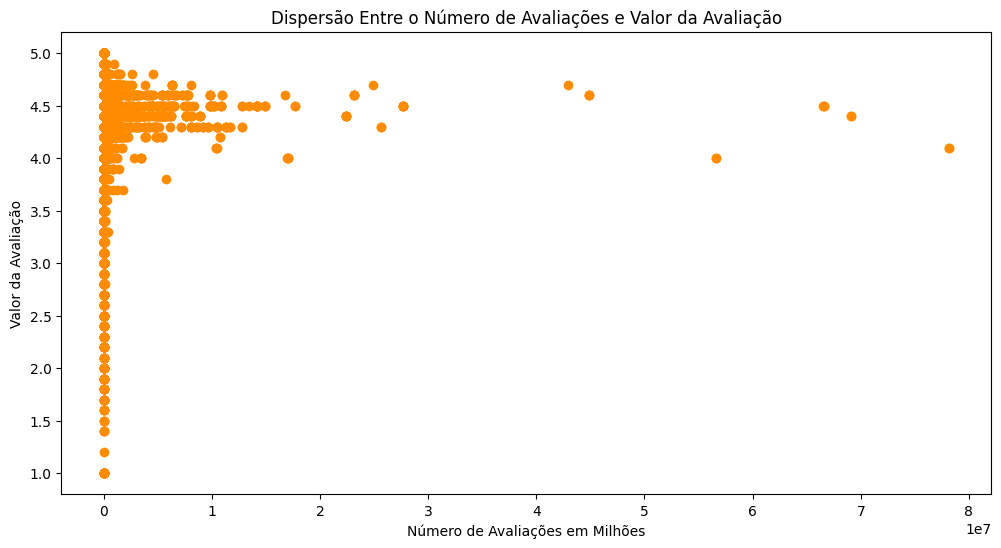

In [45]:
# Filtrando registros com valores de "Rating" dentro do range 1-5
valid_rating_dataframe = valid_reviews_dataframe[
    (valid_reviews_dataframe[RATING] >= 1) & (valid_reviews_dataframe[RATING] <= 5)
].copy(deep=True)

# Convertendo os valores de "Reviews" para float
valid_rating_dataframe[REVIEWS] = valid_rating_dataframe[REVIEWS].astype(float)

# Gerando gráfico de disperção entre "Rating" e "Reviews"_______________________________
plt.figure(figsize=(12, 6))

# Criando o gráfico de dispersão
plt.scatter(valid_rating_dataframe[REVIEWS], valid_rating_dataframe[RATING], color='darkorange')

# Adicionando rótulos e título
plt.xlabel('Número de Avaliações em Milhões')
plt.ylabel('Valor da Avaliação')
plt.title('Dispersão Entre o Número de Avaliações e Valor da Avaliação')

# Exibindo o gráfico
plt.show()

#### Notas de Acordo Com a Categoria e Classificação de Conteúdo

Vamos criar um mapa de calor para verificar a média do valor das avaliações de cada categoria e classificação indicativa.

1. Vamos reutilizar o dataframe com o campo "Category" tratado na parte 1.

2. Após, vamos criar um novo dataframe apenas com as 3 colunas que queremos analisar.

3. Então vamos remover qualquer registro que contenha valor nulo em alguma célula.

4. E por último, vamos gerar o mapa de calor:

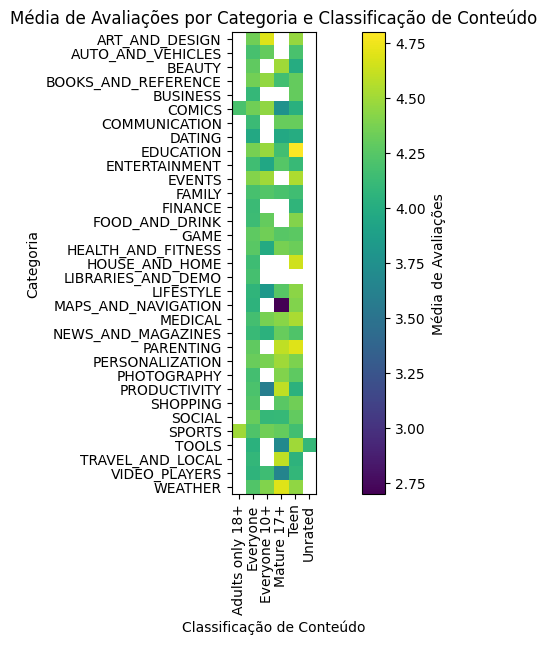

In [46]:
# Filtrando registros com valores de "Rating" dentro do range 1-5
valid_category_rating_dataframe = valid_category_dataframe[
    (valid_category_dataframe[RATING] >= 1) & (valid_category_dataframe[RATING] <= 5)
].copy(deep=True)
 
# Cria um dataframe apenas com as colunas "Category", "Rating" e "Content Rating"
valid_category_content_rating_df = valid_category_rating_dataframe[[CATEGORY, RATING, AGE_RANGE]].dropna()

# Gerando mapa de calor com a média de avaliações por categoria e classificação de conteúdo_____________________

# Cria uma tabela pivô com a média de avaliações por categoria e classificação de conteúdo
pivot_table = valid_category_content_rating_df.pivot_table(
    index=CATEGORY, columns=AGE_RANGE, values=RATING, aggfunc='mean'
)

# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Cria o mapa de calor
plt.imshow(pivot_table, cmap='viridis', interpolation='nearest')

# Adiciona rótulos e título
plt.xlabel('Classificação de Conteúdo')
plt.ylabel('Categoria')
plt.title('Média de Avaliações por Categoria e Classificação de Conteúdo')

# Adiciona a barra de cores
plt.colorbar(label='Média de Avaliações')

# Define os rótulos dos eixos x e y
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns, rotation=90)
plt.yticks(range(len(pivot_table.index)), pivot_table.index)

# Exibe o gráfico
plt.show()